## Causal Machine Learning 
### Two Models for Causal Inference

Importing the data and the necessary libraries

In [2]:
import polars as pl
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.metrics import accuracy_score

In [3]:
data = pl.read_csv("Vocational.csv")

### Exploratory Analysis

First, let's take a look at the data. We will check the first few rows of the data, the data types, and the number of missing values. Then we will either tabulate or plot the distribution of the target variable.

In [4]:
df = data.drop('ind')

In [5]:
df.head()

treatment,age,score,gender,experience,previous_exp,distance_majorcity,owns_motor,placement
i64,i64,i64,str,i64,i64,f64,i64,i64
0,18,75,"""F""",0,0,3.567556,1,0
1,19,73,"""M""",0,0,5.726959,1,0
1,20,77,"""M""",1,16,8.398042,0,1
0,20,71,"""F""",0,0,4.364674,1,0
1,22,78,"""F""",0,0,5.342594,1,0


In [6]:
df = df.with_columns(df['placement'].cast(pl.Utf8).cast(pl.Categorical))

In [7]:
df.group_by('treatment').count()

C:\Users\meala\AppData\Local\Temp\ipykernel_12132\2273299425.py:1: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.
  df.group_by('treatment').count()


treatment,count
i64,u32
1,14968
0,15032


In [8]:
df.group_by('age').count()

C:\Users\meala\AppData\Local\Temp\ipykernel_12132\1984130401.py:1: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.
  df.group_by('age').count()


age,count
i64,u32
18,5910
22,6134
20,5979
19,5908
21,6069


Text(0, 0.5, 'Frequency')

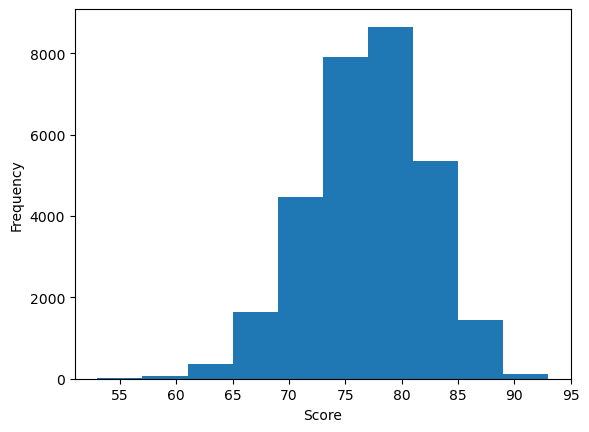

In [9]:
plt.hist(df['score'])
plt.xlabel('Score')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

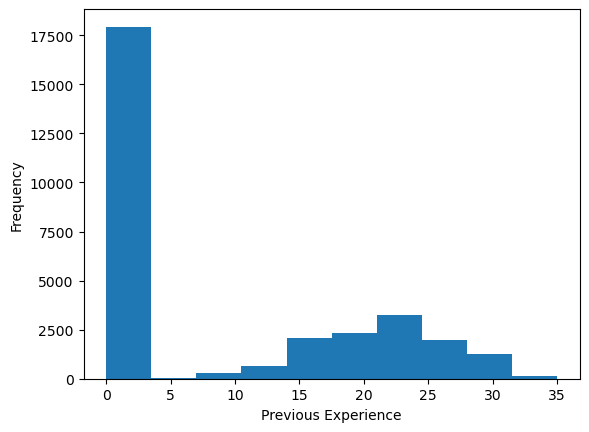

In [10]:
plt.hist(df['previous_exp'])
plt.xlabel('Previous Experience')
plt.ylabel('Frequency')

Most of the individuals have no past experience. The one having experience is noramlly distributed.

Text(0, 0.5, 'Frequency')

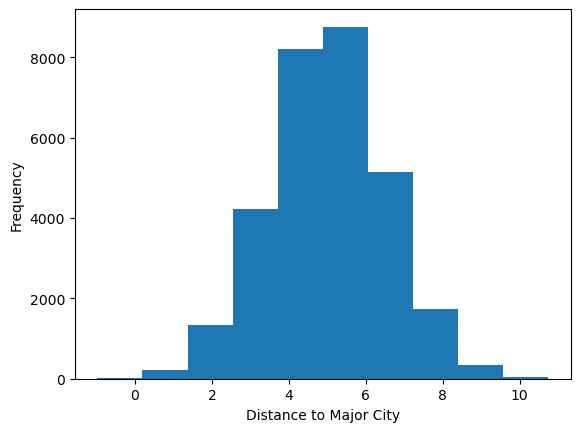

In [11]:
plt.hist(df['distance_majorcity'])
plt.xlabel('Distance to Major City')
plt.ylabel('Frequency')

### Randomized Control Trial

We will start with the Randomized Control Trial. We will split the data into two groups, the control group and the treatment group. We will then calculate the average of the target variable for each group. We will then calculate the average treatment effect.

In [12]:
RCT = data
place_treat = RCT.filter(pl.col('treatment') == 1).select('placement')
place_control = RCT.filter(pl.col('treatment') == 0).select('placement')

In [17]:
place_treat.mean(), place_control.mean()

(shape: (1, 1)
 ┌───────────┐
 │ placement │
 │ ---       │
 │ f64       │
 ╞═══════════╡
 │ 0.323356  │
 └───────────┘,
 shape: (1, 1)
 ┌───────────┐
 │ placement │
 │ ---       │
 │ f64       │
 ╞═══════════╡
 │ 0.176956  │
 └───────────┘)

In [12]:
t_stat, p_value = stats.ttest_ind(place_treat, place_control)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: [29.70663666], P-value: [3.71927462e-191]


The result of the Randomized Control Trial shows significant difference between the control and treatment groups. The treatment group has a higher average target variable.

#### Proportion Tables

In [13]:
contingency_table = pd.crosstab(RCT['treatment'], RCT['placement'])

print(contingency_table)

col_0      0     1
row_0             
0      12372  2660
1      10128  4840


In [14]:
# Proportion table (cell proportions)
proportion_table = contingency_table / contingency_table.sum().sum()

print(proportion_table)

col_0       0         1
row_0                  
0      0.4124  0.088667
1      0.3376  0.161333


### Logistic Regression

Now, let us make use of the logistic regression model. We will fit the model on the data and calculate the impact of each variables.

In [18]:
RCT = df.to_dummies('gender')
RCT = RCT.drop('gender_F')

In [19]:
X_train, X_test, y_train, y_test = train_test_split(RCT.drop('placement'), RCT['placement'], test_size=0.25, random_state=2059)

In [20]:
logit = LogisticRegression()
logit.fit(X_train, y_train)

c:\Users\meala\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [21]:
{'Intercept': logit.intercept_[0], 
              **{X_train.columns[i]: logit.coef_[0][i] for i in range(len(X_train.columns))}}


{'Intercept': -12.820609350730596,
 'treatment': 2.240898875247111,
 'age': -1.427185166816914,
 'score': 0.3674338488803168,
 'gender_M': -0.47010902110297714,
 'experience': 1.5432953449773852,
 'previous_exp': 0.2416802046357105,
 'distance_majorcity': 1.1240717590545486,
 'owns_motor': 1.6221124999737195}

In [22]:
logit.score(X_test, y_test)

0.8988

The model has a high accuracy of 0.89.

### Two Model Uplift

Both RCT and logistic model will now be integrated. We will calculate the uplift for each individual and then calculate the average uplift.

In [20]:
treatment = RCT.filter(pl.col('treatment') == 1)
control = RCT.filter(pl.col('treatment') == 0)

Two different models will be trained. One will be trained only from treatment group and others will be trained from the control group. 

In [21]:
lr_treat = LogisticRegression()
lr_control = LogisticRegression()

In [22]:
lr_treat.fit(treatment.drop('placement','treatment'), treatment['placement'])

c:\Users\meala\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [23]:
lr_control.fit(control.drop('placement','treatment'), control['placement'])

c:\Users\meala\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [24]:
pred_treat = lr_treat.predict_proba(RCT.drop('placement','treatment'))[:, 1]
pred_control = lr_control.predict_proba(RCT.drop('placement','treatment'))[:, 1]

In the full dataset, we will make the prediction from the model trained from the treatment group and the control group. These two predictions will provide the scenario where in first case all individuals receives treatment and in second case no one receives treatment. 

In [25]:
df = df.with_columns(
    pl.Series(pred_treat).alias('pred_treat'),
    pl.Series(pred_control).alias('pred_control')
)
df.head(10)


treatment,age,score,gender,experience,previous_exp,distance_majorcity,owns_motor,placement,pred_treat,pred_control
i64,i64,i64,str,i64,i64,f64,i64,cat,f64,f64
0,18,75,"""F""",0,0,3.567556,1,"""0""",0.063766,0.002999
1,19,73,"""M""",0,0,5.726959,1,"""0""",0.061389,0.004802
1,20,77,"""M""",1,16,8.398042,0,"""1""",0.973788,0.835999
0,20,71,"""F""",0,0,4.364674,1,"""0""",0.00266,0.000137
1,22,78,"""F""",0,0,5.342594,1,"""0""",0.002626,0.000588
1,20,76,"""M""",0,0,6.842471,0,"""0""",0.022617,0.002578
1,19,78,"""F""",0,0,3.625747,1,"""0""",0.036458,0.003034
1,22,74,"""F""",1,17,3.030775,1,"""0""",0.023168,0.00191
0,19,72,"""F""",0,0,3.267415,0,"""0""",0.001068,0.000028


The difference between the two predictions is the uplift.

In [26]:
df = df.with_columns(
    (pl.col('pred_treat') - pl.col('pred_control')).alias('diff')
)
df.head()

treatment,age,score,gender,experience,previous_exp,distance_majorcity,owns_motor,placement,pred_treat,pred_control,diff
i64,i64,i64,str,i64,i64,f64,i64,cat,f64,f64,f64
0,18,75,"""F""",0,0,3.567556,1,"""0""",0.063766,0.002999,0.060766
1,19,73,"""M""",0,0,5.726959,1,"""0""",0.061389,0.004802,0.056587
1,20,77,"""M""",1,16,8.398042,0,"""1""",0.973788,0.835999,0.137789
0,20,71,"""F""",0,0,4.364674,1,"""0""",0.00266,0.000137,0.002522
1,22,78,"""F""",0,0,5.342594,1,"""0""",0.002626,0.000588,0.002038


All individuals will be ranked based on the uplift. This will help us to find the people who will benefit the most from the treatment. The ranking will be done in descending order and divided into 10 groups.

In [27]:
# BEGIN: Create deciles based on the 'diff' column
df = df.with_columns(
    pl.Series(9 - pd.qcut(df['diff'].to_pandas(), 10, labels=False) + 1).alias('decile')
)
df.head(15)
# END: Create deciles based on the 'diff' column

treatment,age,score,gender,experience,previous_exp,distance_majorcity,owns_motor,placement,pred_treat,pred_control,diff,decile
i64,i64,i64,str,i64,i64,f64,i64,cat,f64,f64,f64,i64
0,18,75,"""F""",0,0,3.567556,1,"""0""",0.063766,0.002999,0.060766,6
1,19,73,"""M""",0,0,5.726959,1,"""0""",0.061389,0.004802,0.056587,6
1,20,77,"""M""",1,16,8.398042,0,"""1""",0.973788,0.835999,0.137789,4
0,20,71,"""F""",0,0,4.364674,1,"""0""",0.00266,0.000137,0.002522,9
1,22,78,"""F""",0,0,5.342594,1,"""0""",0.002626,0.000588,0.002038,9
…,…,…,…,…,…,…,…,…,…,…,…,…
0,18,73,"""F""",0,0,4.03203,1,"""0""",0.059423,0.002394,0.057029,6
0,19,68,"""F""",1,15,2.33951,1,"""0""",0.11549,0.002077,0.113413,5
0,20,71,"""M""",1,17,6.09878,1,"""0""",0.787096,0.202383,0.584713,1


In [28]:
df = (df.sort('decile'))
df.head(15)

treatment,age,score,gender,experience,previous_exp,distance_majorcity,owns_motor,placement,pred_treat,pred_control,diff,decile
i64,i64,i64,str,i64,i64,f64,i64,cat,f64,f64,f64,i64
0,20,71,"""M""",1,17,6.09878,1,"""0""",0.787096,0.202383,0.584713,1
1,20,68,"""F""",1,21,7.719158,0,"""1""",0.824791,0.178609,0.646181,1
1,18,69,"""M""",1,18,6.455536,0,"""1""",0.937887,0.280088,0.6578,1
1,21,74,"""F""",1,23,4.513081,1,"""1""",0.581109,0.127589,0.45352,1
0,18,77,"""F""",0,0,6.925587,1,"""0""",0.789313,0.274366,0.514946,1
…,…,…,…,…,…,…,…,…,…,…,…,…
0,20,63,"""M""",1,19,6.401058,1,"""0""",0.440831,0.023813,0.417018,1
1,19,71,"""F""",1,29,5.606926,0,"""1""",0.957112,0.52346,0.433652,1
1,18,73,"""F""",0,0,7.176391,1,"""1""",0.616059,0.096033,0.520026,1


Uplift Dataset

Now, we will find the real impact of treatment in each deciles.

In [29]:
uplift = df.group_by('decile').agg(
    pl.col('treatment').sum().alias('treatment_count'),
    (pl.col('treatment') * pl.col('placement').cast(pl.Float64)).sum().alias('treatment_placement'),
    (1-pl.col('treatment')).sum().alias('control_count'),
    ((1-pl.col('treatment')) * pl.col('placement').cast(pl.Float64)).sum().alias('control_placement')
)
uplift.sort('decile')



decile,treatment_count,treatment_placement,control_count,control_placement
i64,i64,f64,i64,f64
1,1536,959.0,1464,317.0
2,1470,900.0,1530,403.0
3,1482,842.0,1518,408.0
4,1518,617.0,1482,335.0
5,1513,484.0,1487,311.0
6,1464,358.0,1536,271.0
7,1467,279.0,1533,239.0
8,1550,194.0,1450,166.0
9,1468,129.0,1532,143.0


Uplift Cumulative Dataset

It can also be cumulated of each deciles.

In [32]:
uplift_cumulative = uplift

uplift_cumulative = uplift_cumulative.with_columns(
    pl.col('treatment_count').cum_sum().alias('treatment_count_cumulative'),
    pl.col('treatment_placement').cum_sum().alias('treatment_placement_cumulative'),
    pl.col('control_count').cum_sum().alias('control_count_cumulative'),
    pl.col('control_placement').cum_sum().alias('control_placement_cumulative'))

uplift_cumulative


decile,treatment_count,treatment_placement,control_count,control_placement,treatment_count_cumulative,treatment_placement_cumulative,control_count_cumulative,control_placement_cumulative
i64,i64,f64,i64,f64,i64,f64,i64,f64
1,1536,959.0,1464,317.0,1536,959.0,1464,317.0
2,1470,900.0,1530,403.0,3006,1859.0,2994,720.0
3,1482,842.0,1518,408.0,4488,2701.0,4512,1128.0
4,1518,617.0,1482,335.0,6006,3318.0,5994,1463.0
5,1513,484.0,1487,311.0,7519,3802.0,7481,1774.0
6,1464,358.0,1536,271.0,8983,4160.0,9017,2045.0
7,1467,279.0,1533,239.0,10450,4439.0,10550,2284.0
8,1550,194.0,1450,166.0,12000,4633.0,12000,2450.0
9,1468,129.0,1532,143.0,13468,4762.0,13532,2593.0


In [33]:
uplift_cumulative = uplift_cumulative.select(
    pl.col('decile'),
    pl.col('treatment_count_cumulative'),
    pl.col('treatment_placement_cumulative'),
    pl.col('control_count_cumulative'),
    pl.col('control_placement_cumulative')
)

uplift_cumulative

decile,treatment_count_cumulative,treatment_placement_cumulative,control_count_cumulative,control_placement_cumulative
i64,i64,f64,i64,f64
1,1536,959.0,1464,317.0
2,3006,1859.0,2994,720.0
3,4488,2701.0,4512,1128.0
4,6006,3318.0,5994,1463.0
5,7519,3802.0,7481,1774.0
6,8983,4160.0,9017,2045.0
7,10450,4439.0,10550,2284.0
8,12000,4633.0,12000,2450.0
9,13468,4762.0,13532,2593.0


Uplift Average Effect

In [34]:
uplift

decile,treatment_count,treatment_placement,control_count,control_placement
i64,i64,f64,i64,f64
1,1536,959.0,1464,317.0
2,1470,900.0,1530,403.0
3,1482,842.0,1518,408.0
4,1518,617.0,1482,335.0
5,1513,484.0,1487,311.0
6,1464,358.0,1536,271.0
7,1467,279.0,1533,239.0
8,1550,194.0,1450,166.0
9,1468,129.0,1532,143.0


In [36]:
uplift = uplift.with_columns(
   ( (pl.col('treatment_placement')/ pl.col('treatment_count') - pl.col('control_placement')/ pl.col('control_count')) *100).alias('uplift')
)
uplift

decile,treatment_count,treatment_placement,control_count,control_placement,uplift
i64,i64,f64,i64,f64,f64
1,1536,959.0,1464,317.0,40.78189
2,1470,900.0,1530,403.0,34.884621
3,1482,842.0,1518,408.0,29.937644
4,1518,617.0,1482,335.0,18.040998
5,1513,484.0,1487,311.0,11.074832
6,1464,358.0,1536,271.0,6.810323
7,1467,279.0,1533,239.0,3.428059
8,1550,194.0,1450,166.0,1.067853
9,1468,129.0,1532,143.0,-0.546738


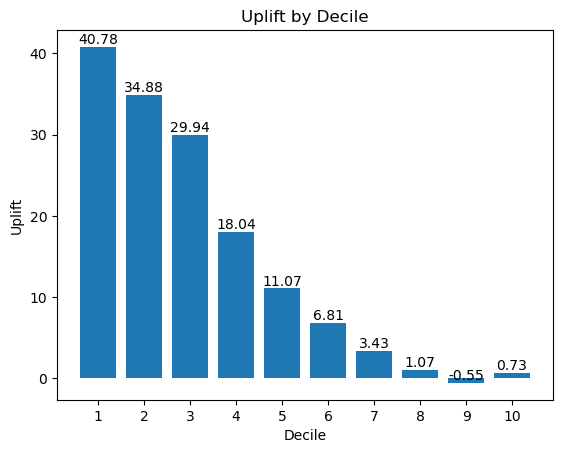

In [42]:

plt.bar(uplift['decile'].cast(pl.Utf8).cast(pl.Categorical), uplift['uplift'])
plt.xlabel('Decile')
plt.ylabel('Uplift')
plt.title('Uplift by Decile')
deciles = uplift['decile'].to_list()
uplift_values = uplift['uplift'].to_list()
for i, value in enumerate(uplift_values):
    plt.text(i, value, f'{value:.2f}', ha='center', va='bottom')
plt.show()

Cumulative Uplift Effect

In [43]:
uplift_cumulative

decile,treatment_count_cumulative,treatment_placement_cumulative,control_count_cumulative,control_placement_cumulative
i64,i64,f64,i64,f64
1,1536,959.0,1464,317.0
2,3006,1859.0,2994,720.0
3,4488,2701.0,4512,1128.0
4,6006,3318.0,5994,1463.0
5,7519,3802.0,7481,1774.0
6,8983,4160.0,9017,2045.0
7,10450,4439.0,10550,2284.0
8,12000,4633.0,12000,2450.0
9,13468,4762.0,13532,2593.0


In [45]:
uplift_cumulative = uplift_cumulative.with_columns(
    (
        pl.col('treatment_placement_cumulative') - 
        (pl.col('control_placement_cumulative') / pl.col('control_count_cumulative')) * pl.col('treatment_count_cumulative')
    ).alias('uplift_cumulative')
)

uplift_cumulative = uplift_cumulative.with_columns(
    (pl.col('uplift_cumulative') / (pl.col('control_count_cumulative').sum()) * 100).alias('uplift_cumulative_percent')
)
uplift_cumulative

decile,treatment_count_cumulative,treatment_placement_cumulative,control_count_cumulative,control_placement_cumulative,uplift_cumulative,uplift_cumulative_percent
i64,i64,f64,i64,f64,f64,f64
1,1536,959.0,1464,317.0,626.409836,0.758586
2,3006,1859.0,2994,720.0,1136.114228,1.375841
3,4488,2701.0,4512,1128.0,1579.0,1.912178
4,6006,3318.0,5994,1463.0,1852.071071,2.242868
5,7519,3802.0,7481,1774.0,2018.988905,2.445007
6,8983,4160.0,9017,2045.0,2122.71099,2.570615
7,10450,4439.0,10550,2284.0,2176.649289,2.635935
8,12000,4633.0,12000,2450.0,2183.0,2.643625
9,13468,4762.0,13532,2593.0,2181.263671,2.641523


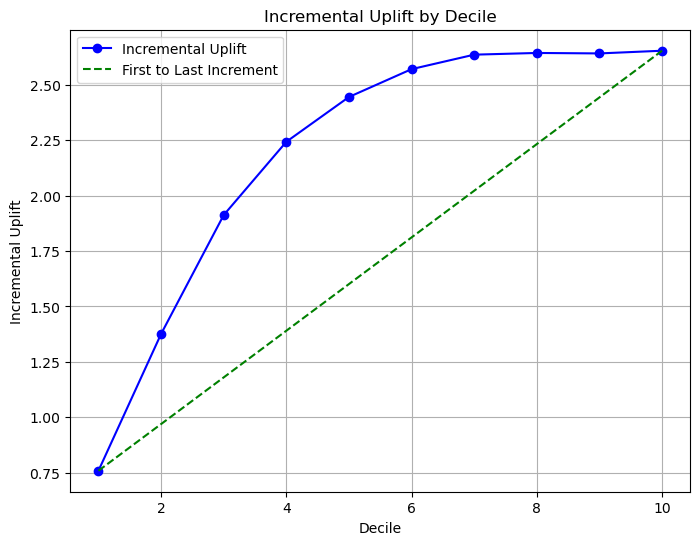

In [50]:
# Create the plot
plt.figure(figsize=(8, 6))
decile = uplift_cumulative['decile'].to_list()
increment_uplift = uplift_cumulative['uplift_cumulative_percent'].to_list()

# Plot line and points for incremental uplift
plt.plot(uplift_cumulative['decile'], uplift_cumulative['uplift_cumulative_percent'], color='blue', label='Incremental Uplift', marker='o')

# Add dashed line between the first and last incremental uplift values
plt.plot([decile[0], decile[-1]], [increment_uplift[0], increment_uplift[-1]], 
         linestyle='dashed', color='green', label="First to Last Increment")

# Add labels and title
plt.title("Incremental Uplift by Decile")
plt.xlabel("Decile")
plt.ylabel("Incremental Uplift")

# Add a legend
plt.legend()

# Display the plot
plt.grid(True)
plt.show()